In [3]:
import pandas as pd

# Load the dataset (Replace 'your_dataset.csv' with actual file)
df_sensors = pd.read_csv("C:\\Users\\hrith\\Desktop\\Data_science_ml\\iot_safety_dataset_136789_updated.csv")

# Drop any existing anomaly columns (Reset Data)
df_sensors = df_sensors.iloc[:, :9]  # Keep only the first 9 columns (sensor values)

# Display dataset info
print("✅ Dataset Information (After Resetting):")
print(df_sensors.info())

# Show first few rows
df_sensors.head()


✅ Dataset Information (After Resetting):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136789 entries, 0 to 136788
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   humidity     136789 non-null  float64
 1   temperature  136789 non-null  float64
 2   distance     136789 non-null  float64
 3   mq2          136789 non-null  float64
 4   mq6          136789 non-null  float64
 5   mq135        136789 non-null  float64
 6   acc_x        136789 non-null  float64
 7   acc_y        136789 non-null  float64
 8   acc_z        136789 non-null  float64
dtypes: float64(9)
memory usage: 9.4 MB
None


,humidity,temperature,distance,mq2,mq6,mq135,acc_x,acc_y,acc_z
0,59.15,15.00,229.92,5766.57,7714.05,813.31,2.08,0.22,1.93
1,54.00,39.28,18.59,4440.09,3007.55,407.55,-0.20,-1.74,-1.12
2,67.24,27.85,266.83,2379.75,4216.47,206.32,1.18,2.09,0.53
3,65.90,37.17,21.40,2982.46,4214.45,492.78,-1.37,0.41,-1.65
4,24.50,42.64,247.61,1789.99,580.75,150.89,-0.58,2.09,-1.95


# isolation forest


In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# Initialize Isolation Forest (contamination = 0.05)
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)

# 📌 Train the model & store results in a new column
df_sensors['anomaly_iso_forest'] = iso_forest.fit_predict(df_sensors.iloc[:, :9])

# Convert anomaly labels (-1: Anomaly, 1: Normal)
df_sensors['anomaly_iso_forest'] = df_sensors['anomaly_iso_forest'].map({1: 'Normal', -1: 'Anomaly'})

# 📌 Count detected anomalies
print(f"🔹 Isolation Forest Anomaly Counts:\n{df_sensors['anomaly_iso_forest'].value_counts()}")


🔹 Isolation Forest Anomaly Counts:
anomaly_iso_forest
Normal     129949
Anomaly      6840
Name: count, dtype: int64


In [5]:
df_sensors.head()

,humidity,temperature,distance,mq2,mq6,mq135,acc_x,acc_y,acc_z,anomaly_iso_forest
0,59.15,15.00,229.92,5766.57,7714.05,813.31,2.08,0.22,1.93,Normal
1,54.00,39.28,18.59,4440.09,3007.55,407.55,-0.20,-1.74,-1.12,Normal
2,67.24,27.85,266.83,2379.75,4216.47,206.32,1.18,2.09,0.53,Normal
3,65.90,37.17,21.40,2982.46,4214.45,492.78,-1.37,0.41,-1.65,Normal
4,24.50,42.64,247.61,1789.99,580.75,150.89,-0.58,2.09,-1.95,Normal


# LocalOutlierFactor


In [6]:
from sklearn.neighbors import LocalOutlierFactor

# Initialize LOF (contamination = 0.05)
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)

# 📌 Train the model & store results in a new column
df_sensors['anomaly_lof'] = lof.fit_predict(df_sensors.iloc[:, :9])

# Convert anomaly labels (-1: Anomaly, 1: Normal)
df_sensors['anomaly_lof'] = df_sensors['anomaly_lof'].map({1: 'Normal', -1: 'Anomaly'})

# 📌 Count detected anomalies
print(f"🔹 LOF Anomaly Counts:\n{df_sensors['anomaly_lof'].value_counts()}")


🔹 LOF Anomaly Counts:
anomaly_lof
Normal     129949
Anomaly      6840
Name: count, dtype: int64


In [7]:
df_sensors.head()

,humidity,temperature,distance,mq2,mq6,mq135,acc_x,acc_y,acc_z,anomaly_iso_forest,anomaly_lof
0,59.15,15.00,229.92,5766.57,7714.05,813.31,2.08,0.22,1.93,Normal,Normal
1,54.00,39.28,18.59,4440.09,3007.55,407.55,-0.20,-1.74,-1.12,Normal,Normal
2,67.24,27.85,266.83,2379.75,4216.47,206.32,1.18,2.09,0.53,Normal,Normal
3,65.90,37.17,21.40,2982.46,4214.45,492.78,-1.37,0.41,-1.65,Normal,Normal
4,24.50,42.64,247.61,1789.99,580.75,150.89,-0.58,2.09,-1.95,Normal,Normal


# K MEANS

In [8]:
from sklearn.cluster import KMeans

# Number of clusters (assuming normal behavior follows the majority)
num_clusters = 3  

# Initialize & fit K-Means
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
df_sensors['cluster'] = kmeans.fit_predict(df_sensors.iloc[:, :9])

# Compute distances from cluster centers
df_sensors['kmeans_distance'] = np.linalg.norm(df_sensors.iloc[:, :9] - kmeans.cluster_centers_[df_sensors['cluster']], axis=1)

# Define anomaly threshold (top 5% farthest points)
threshold = np.percentile(df_sensors['kmeans_distance'], 95)
df_sensors['anomaly_kmeans'] = df_sensors['kmeans_distance'] > threshold

# Convert to categorical labels
df_sensors['anomaly_kmeans'] = df_sensors['anomaly_kmeans'].map({True: 'Anomaly', False: 'Normal'})

# 📌 Count detected anomalies
print(f"🔹 K-Means Anomaly Counts:\n{df_sensors['anomaly_kmeans'].value_counts()}")


🔹 K-Means Anomaly Counts:
anomaly_kmeans
Normal     129949
Anomaly      6840
Name: count, dtype: int64


In [9]:
df_sensors.head()

,humidity,temperature,distance,mq2,mq6,mq135,acc_x,acc_y,acc_z,anomaly_iso_forest,anomaly_lof,cluster,kmeans_distance,anomaly_kmeans
0,59.15,15.00,229.92,5766.57,7714.05,813.31,2.08,0.22,1.93,Normal,Normal,1,1493.124923,Normal
1,54.00,39.28,18.59,4440.09,3007.55,407.55,-0.20,-1.74,-1.12,Normal,Normal,2,1022.138373,Normal
2,67.24,27.85,266.83,2379.75,4216.47,206.32,1.18,2.09,0.53,Normal,Normal,2,1477.933898,Normal
3,65.90,37.17,21.40,2982.46,4214.45,492.78,-1.37,0.41,-1.65,Normal,Normal,2,929.822349,Normal
4,24.50,42.64,247.61,1789.99,580.75,150.89,-0.58,2.09,-1.95,Normal,Normal,0,927.082616,Normal


# DBSCAN

In [10]:
from sklearn.cluster import DBSCAN

# Re-tune DBSCAN (adjust `eps` and `min_samples`)
dbscan = DBSCAN(eps=1, min_samples=3)  # Try different values here
df_sensors['anomaly_dbscan'] = dbscan.fit_predict(df_sensors.iloc[:, :9])

# Convert anomaly labels (-1: Anomaly, others: Normal)
df_sensors['anomaly_dbscan'] = df_sensors['anomaly_dbscan'].apply(lambda x: 'Anomaly' if x == -1 else 'Normal')

# 📌 Count detected anomalies
print(f"🔹 DBSCAN Anomaly Counts (After Fixing):\n{df_sensors['anomaly_dbscan'].value_counts()}")


🔹 DBSCAN Anomaly Counts (After Fixing):
anomaly_dbscan
Anomaly    136789
Name: count, dtype: int64


# Elliptic Envelope (Statistical-Based)

In [11]:
from sklearn.covariance import EllipticEnvelope

# Initialize Elliptic Envelope (contamination = 0.05)
elliptic = EllipticEnvelope(contamination=0.05)

# 📌 Train the model & store results in a new column
df_sensors['anomaly_elliptic'] = elliptic.fit_predict(df_sensors.iloc[:, :9])

# Convert anomaly labels (-1: Anomaly, 1: Normal)
df_sensors['anomaly_elliptic'] = df_sensors['anomaly_elliptic'].map({1: 'Normal', -1: 'Anomaly'})

# 📌 Count detected anomalies
print(f"🔹 Elliptic Envelope Anomaly Counts:\n{df_sensors['anomaly_elliptic'].value_counts()}")


🔹 Elliptic Envelope Anomaly Counts:
anomaly_elliptic
Normal     129949
Anomaly      6840
Name: count, dtype: int64


# train basic auto encoder

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler

# 🔹 Scale data (Autoencoders work best with scaled data)
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_sensors.iloc[:, :9])  # Use only sensor values

# 🔹 Autoencoder Architecture
input_dim = df_scaled.shape[1]  # Number of features
encoding_dim = 4  # Bottleneck layer

input_layer = Input(shape=(input_dim,))
encoded = Dense(6, activation='relu')(input_layer)
encoded = Dense(encoding_dim, activation='relu')(encoded)  # Compressed representation

decoded = Dense(6, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)  # Reconstruct original input

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# 🔹 Train Autoencoder
history = autoencoder.fit(df_scaled, df_scaled, epochs=50, batch_size=64, shuffle=True, validation_split=0.1, verbose=1)

# 🔹 Compute Reconstruction Errors
reconstructed_data = autoencoder.predict(df_scaled)
reconstruction_errors = np.mean(np.abs(reconstructed_data - df_scaled), axis=1)

# 🔹 Define Anomaly Threshold (Top 5% of highest reconstruction errors)
threshold = np.percentile(reconstruction_errors, 95)
df_sensors['anomaly_autoencoder'] = reconstruction_errors > threshold
df_sensors['anomaly_autoencoder'] = df_sensors['anomaly_autoencoder'].map({True: 'Anomaly', False: 'Normal'})

# 🔹 Count Anomalies
print(f"🔹 Autoencoder Anomaly Counts:\n{df_sensors['anomaly_autoencoder'].value_counts()}")


Epoch 1/50
1924/1924 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0333 - val_loss: 0.0173
Epoch 2/50
1924/1924 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0171 - val_loss: 0.0172
Epoch 3/50
1924/1924 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0170 - val_loss: 0.0172
Epoch 4/50
1924/1924 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0170 - val_loss: 0.0172
Epoch 5/50
1924/1924 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0171 - val_loss: 0.0172
Epoch 6/50
1924/1924 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0170 - val_loss: 0.0172
Epoch 7/50
1924/1924 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0170 - val_loss: 0.0172
Epoch 8/50
1924/1924 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0170 - val_loss: 0.0173
Epoch 9/50
1924/1924 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0170 - val_loss: 0.0172
Epoch 10/50
1924/1924 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0170 - val_loss: 0.0172
Epoch 11/50
1924/1924 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0170 - val_loss: 0.0172
Epoch 12/50
1924/1924 ━━━━━━━━

# Reconstruction Error Distribution

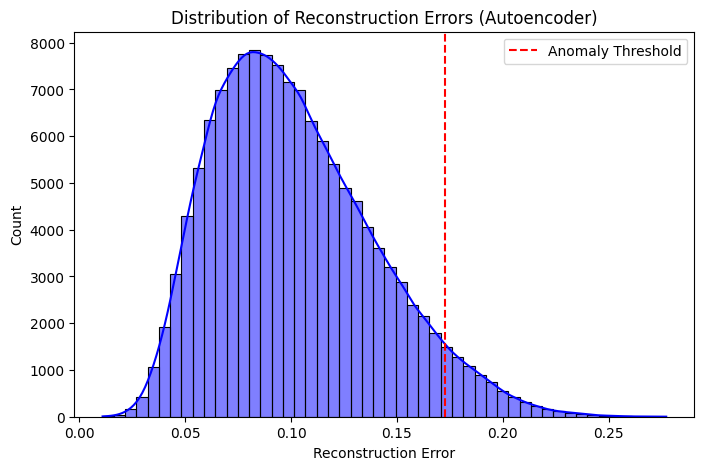

In [13]:
plt.figure(figsize=(8, 5))
sns.histplot(reconstruction_errors, bins=50, kde=True, color='blue')
plt.axvline(threshold, color='red', linestyle='dashed', label="Anomaly Threshold")
plt.xlabel("Reconstruction Error")
plt.ylabel("Count")
plt.title("Distribution of Reconstruction Errors (Autoencoder)")
plt.legend()
plt.show()


# Boxplots for Normal vs. Anomalies

C:\Users\hrith\AppData\Local\Temp\ipykernel_32596\63374861.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_sensors['anomaly_autoencoder'], y=df_sensors[feature], ax=axes[i], palette={'Normal': 'blue', 'Anomaly': 'red'})
C:\Users\hrith\AppData\Local\Temp\ipykernel_32596\63374861.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_sensors['anomaly_autoencoder'], y=df_sensors[feature], ax=axes[i], palette={'Normal': 'blue', 'Anomaly': 'red'})
C:\Users\hrith\AppData\Local\Temp\ipykernel_32596\63374861.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the sam

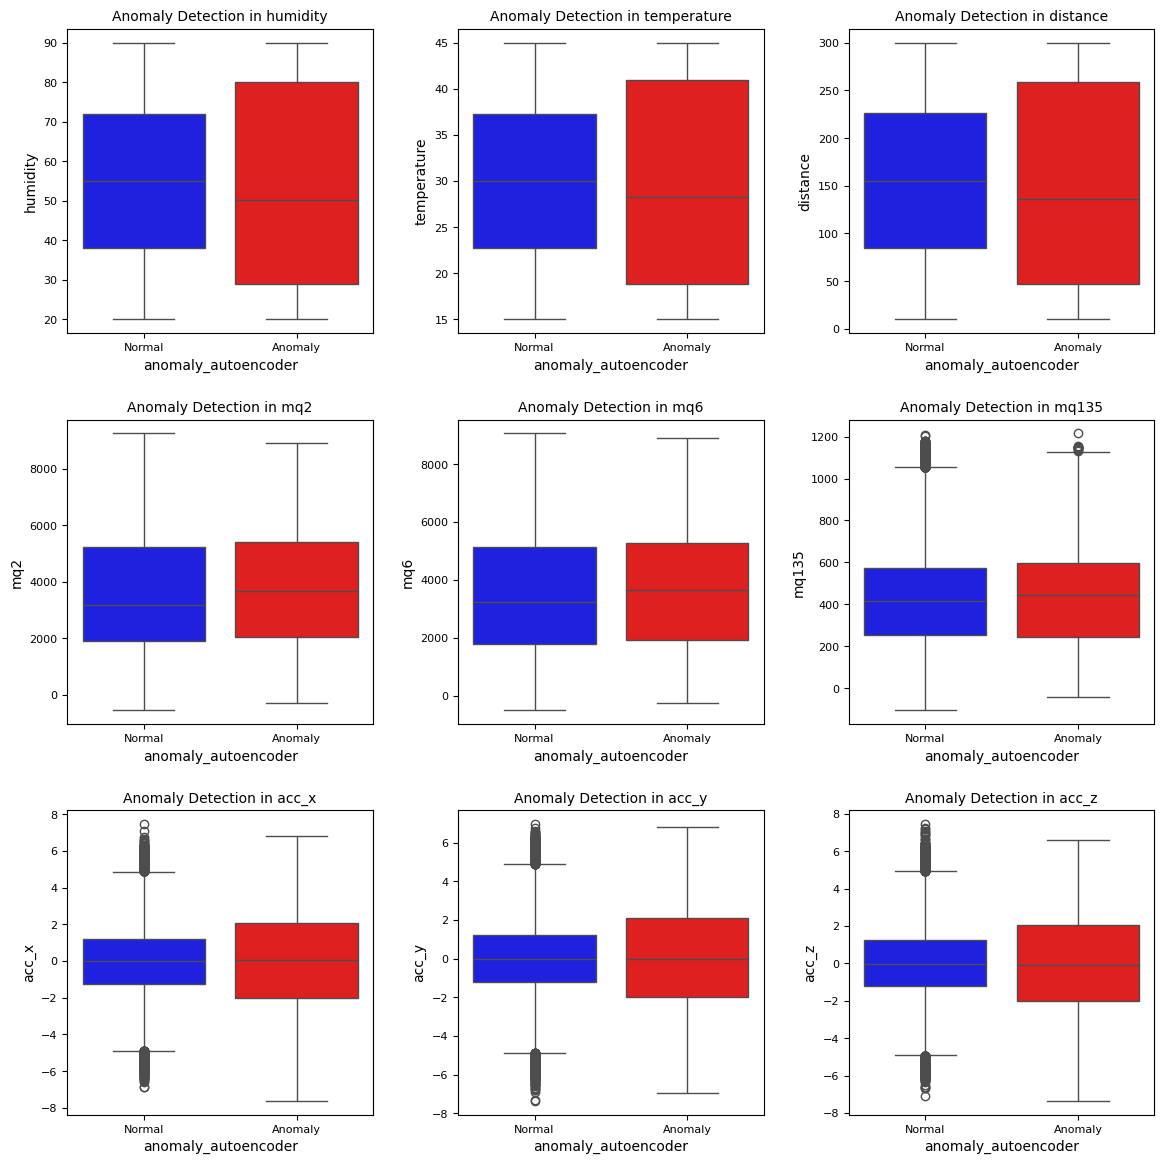

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Only sensor columns
features = df_sensors.columns[:9]

# Create a grid of subplots (use ceil to calculate the appropriate grid size)
n_cols = 3  # Number of columns in the grid
n_rows = (len(features) + n_cols - 1) // n_cols  # Number of rows needed

# Create the figure with a smaller size to fit the research paper layout
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 4))

# Flatten the axes to make it easier to iterate over
axes = axes.flatten()

# Loop through the features and create boxplots
for i, feature in enumerate(features):
    sns.boxplot(x=df_sensors['anomaly_autoencoder'], y=df_sensors[feature], ax=axes[i], palette={'Normal': 'blue', 'Anomaly': 'red'})
    axes[i].set_title(f"Anomaly Detection in {feature}", fontsize=10)
    axes[i].tick_params(axis='both', labelsize=8)

# Remove any unused axes if the grid is not fully filled
for i in range(len(features), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout to avoid overlap
plt.tight_layout(pad=2.0)
plt.show()


In [15]:
df_sensors.head()

,humidity,temperature,distance,mq2,mq6,mq135,acc_x,acc_y,acc_z,anomaly_iso_forest,anomaly_lof,cluster,kmeans_distance,anomaly_kmeans,anomaly_dbscan,anomaly_elliptic,anomaly_autoencoder
0,59.15,15.00,229.92,5766.57,7714.05,813.31,2.08,0.22,1.93,Normal,Normal,1,1493.124923,Normal,Anomaly,Normal,Normal
1,54.00,39.28,18.59,4440.09,3007.55,407.55,-0.20,-1.74,-1.12,Normal,Normal,2,1022.138373,Normal,Anomaly,Normal,Normal
2,67.24,27.85,266.83,2379.75,4216.47,206.32,1.18,2.09,0.53,Normal,Normal,2,1477.933898,Normal,Anomaly,Normal,Normal
3,65.90,37.17,21.40,2982.46,4214.45,492.78,-1.37,0.41,-1.65,Normal,Normal,2,929.822349,Normal,Anomaly,Normal,Normal
4,24.50,42.64,247.61,1789.99,580.75,150.89,-0.58,2.09,-1.95,Normal,Normal,0,927.082616,Normal,Anomaly,Normal,Normal


# Feature Importance: Which Sensors Contribute Most?

C:\Users\hrith\AppData\Local\Temp\ipykernel_32596\3751216269.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_diffs.index, y=mean_diffs.values, palette='coolwarm')


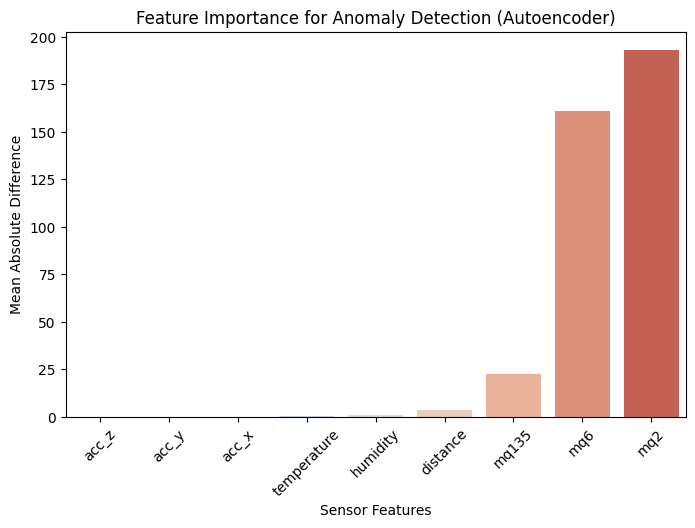

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 🔹 Ensure only numeric sensor features are used
df_numeric = df_sensors.drop(columns=['anomaly_iso_forest', 'anomaly_lof', 'cluster', 
                                      'kmeans_distance', 'anomaly_kmeans', 'anomaly_dbscan', 
                                      'anomaly_elliptic', 'anomaly_autoencoder'])

# 🔹 Compute Mean Absolute Feature Differences (for Autoencoder anomalies)
mean_diffs = df_numeric.groupby(df_sensors['anomaly_autoencoder']).mean().diff().iloc[-1].abs().sort_values()

# 🔹 Plot Feature Importance for Anomaly Detection
plt.figure(figsize=(8, 5))
sns.barplot(x=mean_diffs.index, y=mean_diffs.values, palette='coolwarm')
plt.xticks(rotation=45)
plt.ylabel("Mean Absolute Difference")
plt.xlabel("Sensor Features")
plt.title("Feature Importance for Anomaly Detection (Autoencoder)")
plt.show()


C:\Users\hrith\AppData\Local\Temp\ipykernel_32596\475702105.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_binary = df_sensors[['anomaly_iso_forest', 'anomaly_lof', 'anomaly_kmeans', 'anomaly_elliptic', 'anomaly_autoencoder']].replace({'Normal': 0, 'Anomaly': 1})


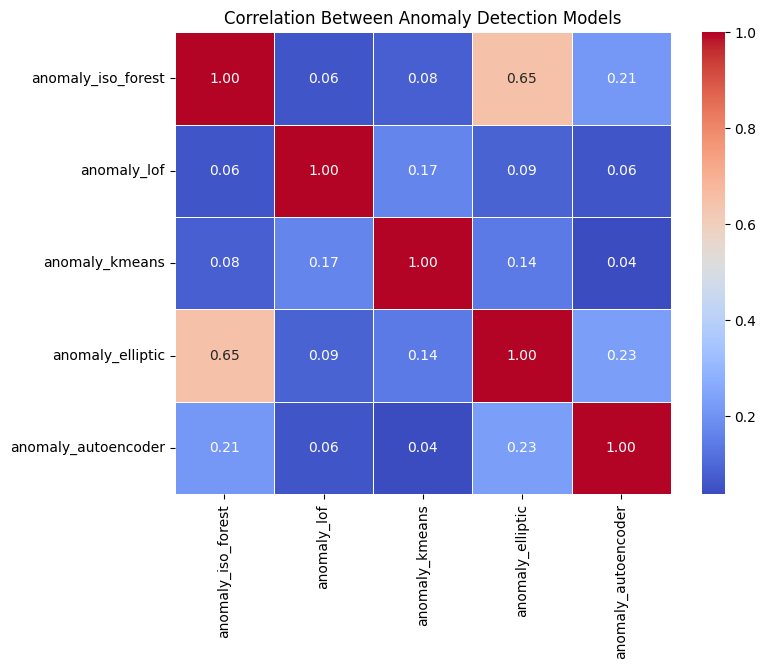

In [17]:
# Convert all anomaly columns to binary (0 = Normal, 1 = Anomaly)
df_binary = df_sensors[['anomaly_iso_forest', 'anomaly_lof', 'anomaly_kmeans', 'anomaly_elliptic', 'anomaly_autoencoder']].replace({'Normal': 0, 'Anomaly': 1})

# Compute correlation between different models
corr_matrix = df_binary.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Between Anomaly Detection Models")
plt.show()
